# Splice site prediction on C. Elegans DNA

## Setup

### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, average_precision_score, roc_auc_score
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.ensemble import BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier

from squiggle import transform

from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


### Load dataset

Encode the dna string as a list of floats

In [2]:
dna_float_encoding_dict = { 'A': 0.25, 'C': 0.5,  'G': 0.75, 'T': 1.0 }

def encode_dna_string_to_floats(dna_string):
    float_encoded_dna = []
    
    for n in dna_string:
        float_encoded_dna.append(dna_float_encoding_dict[n])
    
    return np.array(float_encoded_dna)


In [3]:
df = pd.read_csv('data/C_elegans_acc_seq.csv', names=['labels', 'sequences'])

labels_df = df['labels']
dena_sequences_df = df['sequences']

encoded_dna_sequences = np.array([encode_dna_string_to_floats(c) for c in np.array(dena_sequences_df)])
binary_labels = np.array([0 if x == -1 else 1 for x in np.array(labels_df)])

x_train, x_test, y_train, y_test = train_test_split(encoded_dna_sequences, np.array(labels_df), test_size=0.25, random_state=29)
#x_train, x_test, y_train, y_test = train_test_split(encoded_dna_sequences, binary_labels, test_size=0.25, random_state=29)

### Dtaset analysis

In [4]:
labels = np.array(labels_df)
fraction_of_class1_samples = np.array(labels[labels==1]).shape[0] / labels.shape[0]
print("Class 1 (spline site) contains {0}% of the data samples.".format(round(fraction_of_class1_samples, 2) * 100))
print("For each sample of class 1 there are {0} samples of class -1".format(1/fraction_of_class1_samples))

number_of_features = x_train.shape[1]
print("Each sample consists of {0} features, i.e. nucleotides".format(number_of_features))

Class 1 (spline site) contains 9.0% of the data samples.
For each sample of class 1 there are 11.0 samples of class -1
Each sample consists of 82 features, i.e. nucleotides


The C. Elegans data set is highly unbalanced. the non-spline sites make more than 90% of the data set. 

In [5]:
a =  transform(dena_sequences_df[0], method='gates')
print(a)

([0, 0, -1, -1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 5, 6, 6, 7, 7, 6, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 4, 3, 3, 3, 3, 4, 5, 5, 6, 6, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 10, 9, 9], [0, -1, -1, 0, 0, 0, 0, -1, 0, -1, -2, -1, 0, 1, 1, 0, -1, -2, -2, -3, -4, -3, -4, -5, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 3, 2, 1, 2, 3, 3, 4, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6, 7, 8, 8, 8, 7, 8, 8, 8, 7, 6, 5, 5, 5, 4, 4, 5, 5, 5, 4, 5, 5, 4, 5, 5, 6, 7, 7, 6, 6, 6, 5])


<Figure size 1120x960 with 0 Axes>

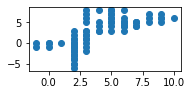

<Figure size 1120x960 with 0 Axes>

In [6]:
plt.subplot(3, 2, 1)
plt.scatter(a[0], a[1])


plt.figure(figsize=(14, 12), dpi= 80, facecolor='w', edgecolor='k')

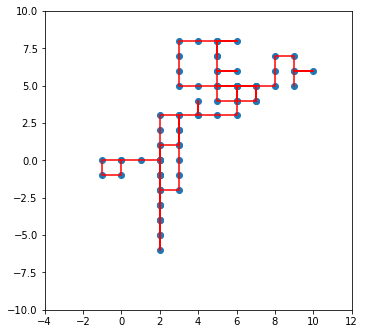

In [7]:
fig = plt.figure(1, figsize=(5.5,5.5))


# the scatter plot:
axScatter = plt.subplot(111)
axScatter.scatter(a[0], a[1])

# set axes range
plt.xlim(-4, 12)
plt.ylim(-10, 10)

plt.plot(a[0], a[1], 'r')

### Helper functions

Takes a model wrapper and evaluates its performance on the provided evaluation set, outputs the OP, PC and IoU and saves the results in a txt file if required.

In [5]:
def evaluate_model(model_wrapper, X, Y_true, verbose=False):
    Y_pred = model_wrapper.predict(X)
    
    f1 = f1_score(Y_true, Y_pred, average="macro")
    acc = accuracy_score(Y_true, Y_pred)
    auroc = roc_auc_score(Y_true, Y_pred)
    auprc = average_precision_score(Y_true, Y_pred)
    cm = confusion_matrix(Y_true, Y_pred)
    acc_per_class = cm.diagonal() / np.sum(cm, axis=1)
    
    if verbose:
        print("\n=================================================================")
        print("\nAccuracy:", round(acc, 5))
        print("F1:      ", round(f1, 5))
        print("AUROC    ", round(auroc, 5))
        print("AUPRC    ", round(auprc, 5))
        print("Confusion matrix:")
        print(cm)
        print("Accuracy per class")
        print(acc_per_class)
        print("\n=================================================================\n")
    return (f1, acc, acc_per_class, auroc, auprc)

Runs K-Fold cross-validation and pretty-prints intermediate results.

In [12]:
def cross_validation(model_wrapper, X, Y, folds=10, message=''):
    kf = KFold(n_splits=folds, shuffle=True)
    i = 0.
    f1_a = 0
    acc_a = 0
    acc_per_class_a = 0
    auroc_a = 0
    auprc_a = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model_wrapper.fit(X_train, Y_train)
        f1, acc, acc_per_class, auroc, auprc = evaluate_model(model_wrapper, X_test, Y_test)
        f1_a += f1
        acc_a += acc
        acc_per_class_a += acc_per_class
        auroc_a += auroc
        auprc_a += auprc
        i += 1
    print("\n=================================================================")
    if message != '':
        print(message)
    print("\nAverage Accuracy:", round(acc_a/i, 5))
    print("Average F1:      ", round(f1_a/i, 5))
    print("Average AUPRC:      ", round(auprc_a/i, 5))
    print("Average AUROC:      ", round(auroc_a/i, 5))
    print("Average Accuracy per class")
    print(acc_per_class_a / i)
    print("\n=================================================================\n")

In [7]:
class Sklearn_Model_Wrapper():
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, Y):
        self.model.fit(X, Y)
    
    def predict(self, X):
        return self.model.predict(X)

In [8]:
class Keras_Model_Wrapper():
    def __init__(self, model, batch_size=64, epochs=10, class_weights={0:1, 1:1}):
        self.model = model
        self.epochs = epochs
        self.batch_size = batch_size
        self.class_weights = class_weights
    
    def fit(self, X, Y):
        ohe = OneHotEncoder()
        one_hot_encoded_y = ohe.fit_transform(Y.reshape(-1, 1)).toarray()
        self.model.fit(X, one_hot_encoded_y, class_weight=self.class_weights, 
                       batch_size=self.batch_size, epochs=self.epochs, verbose=0)
    
    def predict(self, X):
        probas = self.model.predict(X)
        predictions = np.argmax(probas, axis=1)
        return np.array([-1 if x == 0 else 1 for x in predictions])

## Models

### SVM

In [13]:
svm = Sklearn_Model_Wrapper(LinearSVC(random_state=0, tol=1e-5, max_iter=2000))

cross_validation(svm, x_train, y_train)



Average Accuracy: 0.91394
Average F1:       0.66453
Average AUPRC:       0.21742
Average AUROC:       0.63865
Average Accuracy per class
[0.97210135 0.30519059]




In [17]:
weights = {-1:0.1, 1:1}
svm = Sklearn_Model_Wrapper(LinearSVC(random_state=0, tol=1e-5, max_iter=5000, class_weight=weights))

cross_validation(svm, x_train, y_train)



Average Accuracy: 0.81758
Average F1:       0.65798
Average Accuracy per class
[0.81990876 0.77870215]




In [29]:
weights = {-1:1, 1:10}
svm = Sklearn_Model_Wrapper(LinearSVC(random_state=0, tol=1e-5, max_iter=10000, class_weight=weights))

cross_validation(svm, x_train, y_train)

C:\Users\m_lev\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 



Average Accuracy: 0.82485
Average F1:       0.66426
Average Accuracy per class
[0.82845915 0.77203548]




In [36]:
weights = {-1:1, 1:10}
svm = Sklearn_Model_Wrapper(SVC(random_state=0, tol=1e-5, max_iter=10000, class_weight=weights, kernel='poly'))

cross_validation(svm, x_train, y_train)

C:\Users\m_lev\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\m_lev\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\m_lev\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\m_lev\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni



Average Accuracy: 0.78788
Average F1:       0.64461
Average Accuracy per class
[0.77827839 0.88528945]




### Random Forest

In [14]:
random_forest = Sklearn_Model_Wrapper(RandomForestClassifier(max_depth=2, random_state=0))

cross_validation(random_forest, x_train, y_train)



Average Accuracy: 0.91333
Average F1:       0.47732
Average Accuracy per class
[1. 0.]




In [15]:
random_forest = Sklearn_Model_Wrapper(RandomForestClassifier(max_depth=80, random_state=0, bootstrap=True))

cross_validation(random_forest, x_train, y_train)



Average Accuracy: 0.91879
Average F1:       0.54185
Average Accuracy per class
[0.99870124 0.07446312]




#### Balanced Random Forest
As proposed in Breiman (2001), random forest induces each constituent tree from a bootstrap sample of thetraining data. In learning extremely imbalanced data, there is a significant probability that a bootstrap samplecontains few or even none of the minority class, resulting in a tree with poor performance for predictingthe minority class.   A na ̈ıve way of fixing this problem is to use a stratified bootstrap;  i.e.,  sample with replacement from within each class.  
This still does not solve the imbalance problem entirely.  As recentresearch shows (e.g., Ling & Li (1998),Kubat & Matwin (1997),Drummond & Holte (2003)), for the treeclassifier, artificially making class priors equal either by down-sampling the majority class or over-samplingthe minority class is usually more effective with respect to a given performance measurement, and that down-sampling seems to have an edge over over-sampling. However, down-sampling the majority class may resultin loss of information, as a large part of the majority class is not used. Random forest inspired us to ensembletrees induced from balanced down-sampled data.  
[Ref: https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf]

##### Max deph
Compare different values for the maximal depth of the trees.

In [24]:
print("")
for i in range(2, 50, 3):
    random_forest_max = Sklearn_Model_Wrapper(BalancedRandomForestClassifier(max_depth=i, random_state=0))
    cross_validation(random_forest_max, x_train, y_train, message="10 fold CV for max depth={0}:".format(i))



10 fold CV for max depth=2:

Average Accuracy: 0.85515
Average F1:       0.72456
Average Accuracy per class
[0.84509992 0.94944444]



10 fold CV for max depth=5:

Average Accuracy: 0.86485
Average F1:       0.73472
Average Accuracy per class
[0.85564973 0.95063492]



10 fold CV for max depth=8:

Average Accuracy: 0.87091
Average F1:       0.74108
Average Accuracy per class
[0.86373979 0.93760971]



10 fold CV for max depth=11:

Average Accuracy: 0.8703
Average F1:       0.74034
Average Accuracy per class
[0.86309022 0.93760971]



10 fold CV for max depth=14:

Average Accuracy: 0.8703
Average F1:       0.74034
Average Accuracy per class
[0.86309022 0.93760971]



10 fold CV for max depth=17:

Average Accuracy: 0.8703
Average F1:       0.74034
Average Accuracy per class
[0.86309022 0.93760971]



10 fold CV for max depth=20:

Average Accuracy: 0.8703
Average F1:       0.74034
Average Accuracy per class
[0.86309022 0.93760971]



10 fold CV for max depth=23:

Average Accuracy: 0.870

In [25]:
random_forest_max8 = Sklearn_Model_Wrapper(BalancedRandomForestClassifier(max_depth=i, random_state=0))
cross_validation(random_forest_max8, x_train, y_train, message="max depth={0}:".format(8))

random_forest_max9 = Sklearn_Model_Wrapper(BalancedRandomForestClassifier(max_depth=i, random_state=0))
cross_validation(random_forest_max9, x_train, y_train, message="max depth={0}:".format(9))

random_forest_max10 = Sklearn_Model_Wrapper(BalancedRandomForestClassifier(max_depth=i, random_state=0))
cross_validation(random_forest_max10, x_train, y_train, message="max depth={0}:".format(10))


max depth=8:

Average Accuracy: 0.8703
Average F1:       0.74034
Average Accuracy per class
[0.86309022 0.93760971]



max depth=9:

Average Accuracy: 0.8703
Average F1:       0.74034
Average Accuracy per class
[0.86309022 0.93760971]



max depth=10:

Average Accuracy: 0.8703
Average F1:       0.74034
Average Accuracy per class
[0.86309022 0.93760971]




In [27]:
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',random_state=17)
random_forest_max8 = Sklearn_Model_Wrapper(rusboost)
cross_validation(random_forest_max8, x_train, y_train)



Average Accuracy: 0.89091
Average F1:       0.72985
Average Accuracy per class
[0.91017886 0.6787535 ]




his algorithm is known as EasyEnsemble. The classifier is an ensemble of AdaBoost learners trained on different balanced boostrap samples. The balancing is achieved by random under-sampling.  

[Ref: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.EasyEnsembleClassifier.html#imblearn.ensemble.EasyEnsembleClassifier]

In [29]:
eec_200 = EasyEnsembleClassifier(n_estimators=200, random_state=17)
eec_wrapper = Sklearn_Model_Wrapper(eec_200)
cross_validation(random_forest_max8, x_train, y_train)



Average Accuracy: 0.9
Average F1:       0.77992
Average Accuracy per class
[0.89553779 0.93475257]




In [39]:
eec_400 = EasyEnsembleClassifier(n_estimators=400, random_state=17, n_jobs=4)
eec_wrapper = Sklearn_Model_Wrapper(eec_400)
cross_validation(eec_wrapper, x_train, y_train)



Average Accuracy: 0.90061
Average F1:       0.78018
Average Accuracy per class
[0.89626682 0.93475257]




In [33]:
eec_600 = EasyEnsembleClassifier(n_estimators=600, random_state=17, n_jobs=4)
eec_wrapper = Sklearn_Model_Wrapper(eec_600)
cross_validation(eec_wrapper, eec_wrapper, x_train, y_train)



Average Accuracy: 0.89939
Average F1:       0.77846
Average Accuracy per class
[0.89491988 0.93475257]




In [34]:
eec_600 = EasyEnsembleClassifier(n_estimators=400, random_state=17, n_jobs=4, replacement=True)
eec_wrapper = Sklearn_Model_Wrapper(eec_600)
cross_validation(eec_wrapper, x_train, y_train)



Average Accuracy: 0.89333
Average F1:       0.77056
Average Accuracy per class
[0.8882862  0.93475257]




### Logistic Regression

In [26]:
logistic_regression = Sklearn_Model_Wrapper(LogisticRegression(random_state=13, max_iter=200))
cross_validation(logistic_regression, x_train, y_train)



Average Accuracy: 0.91212
Average F1:       0.61782
Average Accuracy per class
[0.97818713 0.20710084]




In [28]:
weights = {-1:1, 1:10}

logistic_regression = LogisticRegression(random_state=13, max_iter=200, class_weight=weights)
logistic_regression_wrapper = Sklearn_Model_Wrapper(logistic_regression)
cross_validation(logistic_regression_wrapper, x_train, y_train)



Average Accuracy: 0.83273
Average F1:       0.67162
Average Accuracy per class
[0.83775179 0.76781979]




In [29]:
weights = {-1:1, 1:100}

logistic_regression = LogisticRegression(random_state=13, max_iter=200, class_weight=weights)
logistic_regression_wrapper = Sklearn_Model_Wrapper(logistic_regression)
cross_validation(logistic_regression_wrapper, x_train, y_train)



Average Accuracy: 0.73152
Average F1:       0.59575
Average Accuracy per class
[0.71584757 0.88220355]




As we set the weights havely towards the minority class we can the the calassifier overfitting to that class.  
In the next experiment we set the class weights to according to the class distribution of the data set. 

In [30]:
weights = {-1:1, 1:11}

logistic_regression = LogisticRegression(random_state=13, max_iter=200, class_weight=weights)
logistic_regression_wrapper = Sklearn_Model_Wrapper(logistic_regression)
cross_validation(logistic_regression_wrapper, x_train, y_train)



Average Accuracy: 0.82606
Average F1:       0.66536
Average Accuracy per class
[0.82976304 0.77370215]




In the next cell we experiment with different solvers. We increase the max. interations as some solver apperently do not converge with few iterations.

In [35]:
weights = {-1:1, 1:11}
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

for solver in solvers:
    logistic_regression = LogisticRegression(random_state=13, max_iter=10000, class_weight=weights, solver=solver)
    logistic_regression_wrapper = Sklearn_Model_Wrapper(logistic_regression)
    cross_validation(logistic_regression_wrapper, x_train, y_train, message='solver={0}'.format(solver))


solver=newton-cg

Average Accuracy: 0.82606
Average F1:       0.66536
Average Accuracy per class
[0.82976304 0.77370215]



solver=lbfgs

Average Accuracy: 0.82606
Average F1:       0.66536
Average Accuracy per class
[0.82976304 0.77370215]



solver=liblinear

Average Accuracy: 0.81758
Average F1:       0.65788
Average Accuracy per class
[0.81992254 0.77870215]




C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: C


solver=sag

Average Accuracy: 0.84182
Average F1:       0.62482
Average Accuracy per class
[0.86915303 0.54507003]




C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: C


solver=saga

Average Accuracy: 0.79152
Average F1:       0.61119
Average Accuracy per class
[0.79227676 0.74387955]




C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Next we use L1 instead of L2 loss. Intuitively L1 seems a better fit than L2 as the features are discrete values.  
Indeed we can observe a slight increase of the F1 score and in the accuracies of both classes for the liblinear solver using L1 loss. 

In [39]:
weights = {-1:1, 1:11}
l1_solvers = ['liblinear', 'saga']

for solver in l1_solvers:
    logistic_regression = LogisticRegression(random_state=13, max_iter=10000, class_weight=weights, solver=solver, penalty='l1')
    logistic_regression_wrapper = Sklearn_Model_Wrapper(logistic_regression)
    cross_validation(logistic_regression_wrapper, x_train, y_train, message='solver={0} and loss=L1'.format(solver))


solver=liblinear and loss=L1

Average Accuracy: 0.8297
Average F1:       0.6711
Average Accuracy per class
[0.83251486 0.78703548]




C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: C


solver=saga and loss=L1

Average Accuracy: 0.79758
Average F1:       0.64197
Average Accuracy per class
[0.79606247 0.80069561]




C:\Users\m_lev\Anaconda3\envs\ml4hc-p4\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Deep Learning

In [15]:
def get_fully_connected_model():
    fully_connected_model = Sequential()
    fully_connected_model.add(Dense(40, activation='relu'))
    fully_connected_model.add(Dense(12, activation='relu'))
    fully_connected_model.add(Dense(2, activation='softmax'))

    fully_connected_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return fully_connected_model

In [16]:
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model())
cross_validation(fully_connected_model_wrapper, x_train, y_train)



Average Accuracy: 0.94485
Average F1:       0.75905
Average Accuracy per class
[0.98741753 0.48571895]




In [32]:
class_weights = {0:1, 1:10}
fully_connected_model_wrapper1 = Keras_Model_Wrapper(get_fully_connected_model(), class_weights=class_weights)
cross_validation(fully_connected_model_wrapper1, x_train, y_train)



Average Accuracy: 0.90545
Average F1:       0.78838
Average Accuracy per class
[0.90820815 0.85164169]




In [38]:
class_weights = {0:1, 1:10}
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model(), class_weights=class_weights, epochs=20)
cross_validation(fully_connected_model_wrapper, x_train, y_train)



Average Accuracy: 0.94242
Average F1:       0.88702
Average Accuracy per class
[0.93960268 0.97564103]




In [16]:
class_weights = {0:1, 1:10}
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model(), class_weights=class_weights, epochs=50)
cross_validation(fully_connected_model_wrapper, x_train, y_train)



Average Accuracy: 0.97515
Average F1:       0.93131
Average AUPRC:       0.8266
Average AUROC:       0.94022
Average Accuracy per class
[0.98338059 0.89705882]




In [34]:
class_weights = {0:1, 1:10}
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model(), class_weights=class_weights, epochs=100)
cross_validation(fully_connected_model_wrapper, x_train, y_train)



Average Accuracy: 0.9903
Average F1:       0.96875
Average Accuracy per class
[0.99407448 0.94820513]




In [22]:
class_weights = {0:1, 1:10}
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model(), class_weights=class_weights, epochs=1000)
cross_validation(fully_connected_model_wrapper, x_train, y_train)



Average Accuracy: 0.98848
Average F1:       0.96079
Average Accuracy per class
[0.99406571 0.92896825]




In [36]:
def get_fully_connected_model2():
    fully_connected_model = Sequential()
    fully_connected_model.add(Dense(20, activation='relu'))
    fully_connected_model.add(Dense(2, activation='softmax'))

    fully_connected_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return fully_connected_model

In [37]:
class_weights = {0:1, 1:10}
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model2(), class_weights=class_weights, epochs=50)
cross_validation(fully_connected_model_wrapper, x_train, y_train)



Average Accuracy: 0.93394
Average F1:       0.85532
Average Accuracy per class
[0.93667388 0.90541635]




In [39]:
class_weights = {0:1, 1:10}
fully_connected_model_wrapper = Keras_Model_Wrapper(get_fully_connected_model2(), class_weights=class_weights, epochs=100)
cross_validation(fully_connected_model_wrapper, x_train, y_train)



Average Accuracy: 0.97212
Average F1:       0.93489
Average Accuracy per class
[0.97511459 0.94589358]


